This will be the data collection and cleaning section of the project. First, I import the necessary libraries.

In [13]:
import pandas as pd
import numpy as np
import praw
import requests
import re
import matplotlib.pyplot as plt

from json import JSONDecodeError

The first part of this project will be to search for relevant stock ticker symbols on r/wallstreetbets. I found a .csv file online which contains the majority of relevant stocks to search for.

In [2]:
nasdaq = pd.read_csv('nasdaq_screener_1621717894156.csv',index_col=0)

I'll quickly check the file, the ticker symbols are represented in the index.

In [3]:
nasdaq.head()

,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
Symbol,,,,,,,,,,
A,Agilent Technologies Inc. Common Stock,$132.30,0.15,0.114%,4.031148e+10,United States,1999.0,1445930,Capital Goods,Electrical Products
AA,Alcoa Corporation Common Stock,$36.14,0.32,0.893%,6.748232e+09,NaN,2016.0,6897873,Basic Industries,Metal Fabrications
AAC,Ares Acquisition Corporation Class A Ordinary ...,$9.78,0.01,0.102%,1.222500e+09,NaN,2021.0,391915,Finance,Business Services
AACG,ATA Creativity Global American Depositary Shares,$2.93,0.04,1.384%,9.288448e+07,China,NaN,314661,Miscellaneous,Service to the Health Industry
AACQ,Artius Acquisition Inc. Class A Common Stock,$9.87,0.01,0.101%,8.938519e+08,United States,2020.0,867592,Finance,Business Services


Get the stocks into a pandas series, and remove any ticker symbols which are too close to commonly used words. Most of the searches for these symbols will be primarily populated by irrelevant data, which will lead to misleading results.

In [4]:
stocks = pd.Series(nasdaq.index)

stocks = stocks[~stocks.str.lower().isin(['a','be','by','bye','age','ago','buy','dd','yolo','to','and','end','fun','ad','ads','bot','ah','ahh','all','alt','am','etc',
                        'an','apps','are','auto','bc','big','bill','bob','net','box','boom','bro','can','cap','care','cars','cat','cc','co','cold','cool',
                        'core','cpa','cry','cs','cuz','bb','d','db','doc','door','earn','east','eat','echo','ego','em','eq','eric','es','et','eth','eva','ew',
                        'eye','eyes','fam','fail','fast','farm','fat','fc','ff','flow','fold','for','form','free','fury','fuse','gl','go','gogo','good','h','ha','has','hall','hi',
                        'hr','id','if','imo','ip','irl','it','itt','jack','jan','job','jobs','k','kids','l','lad','lazy','le','leg','life',
                        'link','lite','ll','lmao','loop','love','m','man','min','mod','ms','nc','now','o','oc','ofc','one','or','pays','peak','phd','post',
                        'rare','rave','road','safe','sa','save','see','ship','shop','sky','moon','so','solo','son','stay','hold','sum','t','ta','taco','tds',
                         'tech','ten','tho','tv','tx','nc','sc','ty','u','v','vc','vs','w','wat','well','wish','wifi','work','x','y','z'])]

Some common words were missed in this step, and will need to be processed later on.

In [5]:
stockslist = stocks.to_list()

This function queries the Reddit Pushshift API. The size of each query is limited to 100, the query will return posts containing the query word/symbol between the specified times (Sep 1, 2020, and Feb 28, 2021).

In [6]:
def scrape_reddit_posts(query,start,end):
    #print(query)
    #query = query
    #url = f"https://api.pushshift.io/reddit/search/comment/?q={query}&subreddit=safemoon&size=500&after={start}&before={end}"
    
    #url = f"https://api.pushshift.io/reddit/search/submission/?subreddit=safemoon&size=500&after={start}&before={end}"
    url = f"https://api.pushshift.io/reddit/search/submission/?q={query}&subreddit=wallstreetbets&size=100&after={start}&before={end}"
    request = requests.get(url)
    return request.json()

The code below makes successive calls to the function above, acquiring all Reddit posts pertaining to each stock symbol. Some try/except clauses are included so that the code can continue running in the event of an error, and just try to fetch the data again until successful.

The code adds the author, post id, subreddit (which is always r/wallstreetbets), post content, post title, score, hyperlink location, timestamp, and the number of comments received by the post to a dataframe, for each post.

The results for each stock symbol were saved to a separate .csv file.

In [ ]:
df_total = pd.DataFrame(columns=["author", "id", "subreddit", "selftext", "num_comments", "score", "title", "permalink","created_utc"])

start_epoch = 1598922001 #sep 1, 2020
end_epoch = 1614556799 #feb 28, 2021

epoch = start_epoch

for i in range(len(stockslist)):
    ticker = stockslist[i]
    print(i)
    print(ticker)
    df_total = pd.DataFrame(columns=["author", "id", "subreddit", "selftext", "num_comments", "score", "title", "permalink","link_flair_css_class","created_utc"])
    epoch = start_epoch
    while epoch < end_epoch:
        try:
            data = scrape_reddit_SFM(ticker,epoch, end_epoch)
            print(len(data['data']))
            if len(data['data']) == 0:
                break
            try:
                epoch = data['data'][-1]["created_utc"] + 1
            except:
                print("error")
            print(epoch)
            df = pd.DataFrame.from_records(data['data'])[["author", "id", "subreddit", "selftext", "num_comments", "score", "title", "permalink","link_flair_css_class","created_utc"]]
            df_total = df_total.append(df)
            print(df_total.shape)
            time.sleep(1)
        except IndexError:
            break
            time.sleep(1)
        except JSONDecodeError:
            time.sleep(3)
    df_total.to_csv('stockdfs/df_' + ticker + '.csv')

Now, I iterate over all the .csv files I saved in the previous steps, combining them into a single dataframe.

In [ ]:
df_all = pd.DataFrame(columns=["author", "id", "subreddit", "selftext", "num_comments", "score", "title", "permalink","link_flair_css_class","created_utc","stock"])
df_all = df_all.set_index('id')
for filename in os.listdir('stockdfs/'):
    print(filename)
    df = pd.read_csv('stockdfs/' + filename,index_col=0)
    df['stock'] = filename.split('_')[1].split('.')[0]
    df = df.set_index('id')
    for index, row in df.iterrows():
        if df_all.index.isin([index]).any():
            df_all.loc[index,'stock'] = df_all.loc[index,'stock'] + '|' + row[9]
        else:
            df_all = df_all.append(row)
    #df_all = df_all.append(df)
    print(df_all.shape)

In [ ]:
df_all.to_csv('df_all.csv')

In [8]:
df_all = pd.read_csv('df_all.csv',index_col=0)

In [9]:
df_all_reset = df_all.sort_values('created_utc').reset_index()

Here, I check whether there are any significant temporal gaps in the data which Pushshift may have missed, which I will need to fill in if so. I first calculate the time difference between each data point, and then plot them.

In [10]:
for i,row in df_all_reset.iterrows():
    if i == 0:
        df_all_reset.loc[i,'timediff'] = 0
    else:
        df_all_reset.loc[i,'timediff'] = df_all_reset.loc[i,'created_utc'] - df_all_reset.loc[i-1,'created_utc']
    if i%10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000


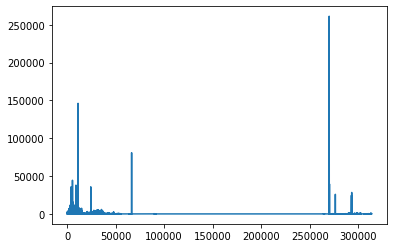

In [14]:
plt.plot(df_all_reset.index,df_all_reset.timediff)

Based on the plot, and the table below, there are some significant outlying time gaps which need to be remedied.

In [11]:
df_all_reset.nlargest(20,'timediff')

,id,author,subreddit,selftext,num_comments,score,title,permalink,link_flair_css_class,created_utc,stock,timediff
270161,leyfdu,endymionsleep,wallstreetbets,[removed],0,1,This post is not about GME,/r/wallstreetbets/comments/leyfdu/this_post_is...,question,1.612740e+09,GME,261266.0
11227,jpa1ic,poache17,wallstreetbets,[removed],6,3,CVS!!!!!! who yolo'd onto that train with me?????,/r/wallstreetbets/comments/jpa1ic/cvs_who_yolo...,profit,1.604686e+09,CVS,146144.0
66445,l6649u,laiod,wallstreetbets,MARKET MANIPULATION BY SOME WALL STREET FUCKS....,12,1,SCHWAB SAYS $GME NOT VALID,/r/wallstreetbets/comments/l6649u/schwab_says_...,question,1.611759e+09,GME,80866.0
5459,izhg70,___rash,wallstreetbets,[removed],0,1,Appl and Tsla went up again,/r/wallstreetbets/comments/izhg70/appl_and_tsl...,stocks,1.601032e+09,TSLA,44478.0
270452,lfd807,judewilloughby,wallstreetbets,[removed],0,1,RKT/TSLA,/r/wallstreetbets/comments/lfd807/rkttsla/,question,1.612795e+09,TSLA|RKT,39566.0
9045,jemp04,aneebus,wallstreetbets,"anyone on ACOR? up 140% pre market, what's goi...",4,1,ACOR,/r/wallstreetbets/comments/jemp04/acor/,question,1.603189e+09,ACOR,38013.0
4082,iv32ip,Aye_Barboza,wallstreetbets,[removed],2,1,TSLA +2.25% pre market. All aboard the spacesh...,/r/wallstreetbets/comments/iv32ip/tsla_225_pre...,NaN,1.600422e+09,TSLA,35820.0
24344,k6cbx2,Jared2338,wallstreetbets,Is their any point in talking about SPY calls ...,16,1,Does anyone talk about SPY anymore?,/r/wallstreetbets/comments/k6cbx2/does_anyone_...,question,1.607051e+09,SPY,35811.0
4787,ixrzmn,DenkiAizen,wallstreetbets,[removed],2,1,NKLA puts,/r/wallstreetbets/comments/ixrzmn/nkla_puts/,question,1.600796e+09,NKLA,34638.0
9044,jedula,wowscool,wallstreetbets,[removed],9,0,Thoughts on NKLA?,/r/wallstreetbets/comments/jedula/thoughts_on_...,question,1.603151e+09,NKLA,31395.0


I construct a list of Reddit IDs with missing values between them.

In [16]:
missing_list = []
for i,row in df_all_reset.nlargest(20,'timediff').iterrows():
    missing_list.append((df_all_reset.loc[i-1,'id'],df_all_reset.loc[i,'id']))

In [17]:
missing_list

[('lcsh9n', 'leyfdu'),
 ('jo9j4g', 'jpa1ic'),
 ('l5hig3', 'l6649u'),
 ('iz7kk5', 'izhg70'),
 ('lf36kb', 'lfd807'),
 ('jedula', 'jemp04'),
 ('iuv61d', 'iv32ip'),
 ('k615qo', 'k6cbx2'),
 ('ixj3kb', 'ixrzmn'),
 ('je3836', 'jedula'),
 ('llqu9p', 'llzzbn'),
 ('lgcxyo', 'lglbr3'),
 ('llfhdp', 'lln8v3'),
 ('ll3xzi', 'llcru4'),
 ('j16ghm', 'j19awr'),
 ('j0l4xv', 'j0o3t3'),
 ('iw9dkx', 'iwc4bl'),
 ('jib16b', 'jidk0d'),
 ('j78j61', 'j7akwo'),
 ('irxi5e', 'is0ntj')]

Using the Reddit PRAW library, and some functions for conversion to reddit ID values (which I did not write, they were available via searching the web for PRAW documentation), I scrape Reddit for the missing IDs, iterating through every ID between the IDs in the list, and storing ones from r/wallstreetbets. Unfortunately, there is no faster alternative I was aware of, and this was a very time-consuming process.

In [ ]:
reddit = praw.Reddit(client_id='-',
                     client_secret='-', password='-',
                     user_agent='-', username='-')

In [ ]:
def base36encode(integer: int) -> str:
    chars = '0123456789abcdefghijklmnopqrstuvwxyz'
    sign = '-' if integer < 0 else ''
    integer = abs(integer)
    result = ''
    while integer > 0:
        integer, remainder = divmod(integer, 36)
        result = chars[remainder] + result
    return sign + result

def base36decode(base36: str) -> int:
    return int(base36, 36)

def get_next_hundred_ids(start_id):
    start_num = base36decode(start_id)
    ids = []
    id_num = -1
    for id_num in range(start_num, start_num + 100):
        ids.append("t3_"+base36encode(id_num))
    return ids, base36encode(id_num)

In [ ]:
df_wsb_new = pd.DataFrame(columns=["author", "id", "subreddit", "selftext", "num_comments", "score", "title", "permalink","link_flair_css_class","created_utc"])

for i in range(0,len(missing_list)):
    start_id_str = missing_list[i][0]
    end_id_str = missing_list[i][1]
    print(start_id_str)
    while True:
        print(start_id_str)
        ids, last_id_str = get_next_hundred_ids(start_id_str)
        first_date = None
        last_date = None
        count_found = 0
        if 't3_'+end_id_str in ids:
            break
        wsb = reddit.subreddit('wallstreetbets')
        submissions = reddit.info(fullnames=ids)
        for submission in submissions:
            count_found += 1
            submission_date = datetime.datetime.fromtimestamp(submission.created_utc)
            if submission.subreddit == 'wallstreetbets' or submission.subreddit == 'Wallstreetbetsnew':
                print(submission.id)
                df_wsb_new = df_wsb_new.append({'author':submission.author,'id':submission.id,'subreddit':submission.subreddit,'selftext':submission.selftext,
                                      'num_comments':submission.num_comments,'score':submission.score,'title':submission.title,'permalink':submission.permalink,
                                      'link_flair_css_class':submission.link_flair_css_class,'created_utc':submission.created_utc},ignore_index=True)
            if first_date is None:
                first_date = submission_date
            last_date = submission_date
        start_id_str = base36encode(base36decode(last_id_str) + 1)

The Pushshift API's info on the number of comments, and the score values of the posts, is also not always accurate, so again I use the PRAW library to acquire more accurate data.

In [ ]:
df_wsb_new = df_wsb_new.set_index('id')

In [ ]:
df_wsb_new.to_csv('wsb_missing.csv')

In [ ]:
wsb = df_all.append(df_wsb_new)

In [ ]:
for i in range(0,int(np.ceil((wsb.shape[0]/100)))):
    firstindex = i*100
    lastindex = (i+1)*100 - 1
    ids = list(wsb.index[firstindex:lastindex])
    ids = ['t3_' + idx for idx in ids]
    print(i)
    submissions = reddit.info(fullnames=ids)
    #print(submissions)
    for submission in submissions:
        #print(submission.id)
        wsb.loc[submission.id,'num_comments_true'] = submission.num_comments
        wsb.loc[submission.id,'score_true'] = submission.score
        wsb.loc[submission.id,'upvote_ratio'] = submission.upvote_ratio

Finally, I acquire the comments for each Reddit submission. Reddit comments are in the form of trees, with the submission as the root, and each reply capable of branching off into more replies. This method of extracting comments was able to preserve this structure, recording the link id (the original post) and the parent id (the comment (or post) being replied to) for each comment.

In [ ]:
count = 0
df_comments = pd.DataFrame(columns=["author", "id","parent_id", "link_id", "subreddit", "body", "score", "permalink", "created_utc"])
for i,row in posts.iterrows():
    count += 1
    submission = reddit.submission(i)
    
    print('num comments:' + str(row['num_comments_true']))
    
    while True:
        try:
            submission.comments.replace_more(limit=None)
            break
        except Exception:
            print("Handling replace_more exception")
            print(len(submission.comments.list()))
    
    for comment in submission.comments.list():

        df_comments = df_comments.append({'author':comment.author,'id':comment.id,'parent_id':comment.parent_id,'link_id':comment.link_id,'subreddit':comment.subreddit,
                           'body':comment.body,'score':comment.score,'permalink':comment.permalink,'created_utc':comment.created_utc},ignore_index=True)

    print(count)
    print(df_comments.shape)

In [ ]:
wsb.to_csv('aaa_posts.csv')
df_comments.to_csv('aaa_comments.csv')

In [18]:
posts = pd.read_csv('aaa_posts.csv',index_col=0)
comments = pd.read_csv('aaa_comments.csv',index_col=0)

C:\Users\nickj\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Here, I do some minor processing of the data before we move on to the next step.

I remove any posts or comments where the author ID is inaccessible, which after the multiple methods used to get the data, took a few different forms.

I also removed comments and posts authored by Reddit bots.

In [ ]:
posts = posts[posts.author != '[deleted]']
posts = posts[~posts.author.isna()]
comments = comments[comments.author != '[deleted]']
comments = comments[~comments.author.isna()]

In [20]:
posts.shape

(334802, 13)

In [21]:
posts.head()

,author,subreddit,selftext,num_comments,score,title,permalink,link_flair_css_class,created_utc,stock,num_comments_true,score_true,upvote_ratio
id,,,,,,,,,,,,,
il7w3w,merp206,wallstreetbets,Alright retards so amc spiked up 15% on news t...,19,1,AMC puts,/r/wallstreetbets/comments/il7w3w/amc_puts/,options,1.599057e+09,AMC,22.0,9.0,0.81
il81vu,JackMaverick7,wallstreetbets,NaN,2,1,$AMC up 15% today already and labor day weeken...,/r/wallstreetbets/comments/il81vu/amc_up_15_to...,question,1.599058e+09,AMC,1.0,1.0,1.00
il848o,JackMaverick7,wallstreetbets,NaN,2,1,$AMC up 15% today already and big viewing numb...,/r/wallstreetbets/comments/il848o/amc_up_15_to...,question,1.599058e+09,AMC,1.0,1.0,1.00
ilhn1t,Wiletj1,wallstreetbets,[removed],2,1,Good Expiration Date for Shorting AMC,/r/wallstreetbets/comments/ilhn1t/good_expirat...,question,1.599088e+09,AMC,1.0,1.0,1.00
ili63n,Wiletj1,wallstreetbets,[removed],2,1,When Are Your AMC Puts Expiring,/r/wallstreetbets/comments/ili63n/when_are_you...,shitpost,1.599089e+09,AMC,1.0,1.0,1.00


In [22]:
comments.shape

(2534510, 9)

In [23]:
comments.head()

,author,id,parent_id,link_id,subreddit,body,score,permalink,created_utc
1,MnVikingsFan34,g3jg6ae,ikazok,ikazok,wallstreetbets,About as likely as me regaining my missing chr...,69,/r/wallstreetbets/comments/ikazok/what_are_the...,1.598924e+09
0,hedgeAgainst,g3jgdna,ikazok,ikazok,wallstreetbets,Not happening. AMZN is the new BRK.A.,93,/r/wallstreetbets/comments/ikazok/what_are_the...,1.598924e+09
252610,RainMan214,g3jgg4f,ikb0s0,ikb0s0,wallstreetbets,Holy shit,2,/r/wallstreetbets/comments/ikb0s0/did_i_win_39...,1.598924e+09
30,hedgeAgainst,g3jgho0,g3jg6ae,ikazok,wallstreetbets,Musk will reveal his new gene therapy next month.,2,/r/wallstreetbets/comments/ikazok/what_are_the...,1.598924e+09
21,RainMan214,g3jgjio,ikazok,ikazok,wallstreetbets,Why not wait till he announces the split? If i...,1,/r/wallstreetbets/comments/ikazok/what_are_the...,1.598924e+09


In [24]:
comments.author.value_counts()

RemindMeBot          2194
WSBVoteBot           2107
OverpricedBagel      1832
pickbot              1712
Unlucky-Prize        1704
                     ... 
FraydoeDeLaTierra       1
itumii                  1
poet1620                1
Captain_Canuck71        1
BigEv17                 1
Name: author, Length: 450695, dtype: int64

In [25]:
comments = comments[~comments.author.isin(['RemindMeBot','WSBVoteBot','pickbot'])]

In [26]:
comments.author.value_counts()

OverpricedBagel       1832
Unlucky-Prize         1704
Dan_inKuwait          1463
Trueslyforaniceguy    1330
Ackilles              1181
                      ... 
librarn1989              1
FraydoeDeLaTierra        1
itumii                   1
poet1620                 1
BigEv17                  1
Name: author, Length: 450692, dtype: int64

In [28]:
posts.author.value_counts()

#NAME?                  164
Onboarding92            140
phan1129                123
True-Law7645             77
kokoloko1010             75
                       ... 
iGOmoon                   1
RealLibertyMatters        1
Kooky-Piccolo1207         1
Intelligent-Tooth-44      1
noahni74                  1
Name: author, Length: 210126, dtype: int64

In [29]:
posts = posts[posts.author != '#NAME?']

In [30]:
posts.author.value_counts()

Onboarding92            140
phan1129                123
True-Law7645             77
kokoloko1010             75
mkaykov                  69
                       ... 
RealLibertyMatters        1
Kooky-Piccolo1207         1
Intelligent-Tooth-44      1
Legitimate-Bite-1180      1
noahni74                  1
Name: author, Length: 210125, dtype: int64

In [31]:
comments = comments[comments.link_id.isin(posts.index)]

In [32]:
comments.shape

(2526827, 9)

At last, I save the posts and comments to .csv files.

In [33]:
posts.to_csv('posts.csv')

In [34]:
comments.to_csv('comments.csv')